In [1]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

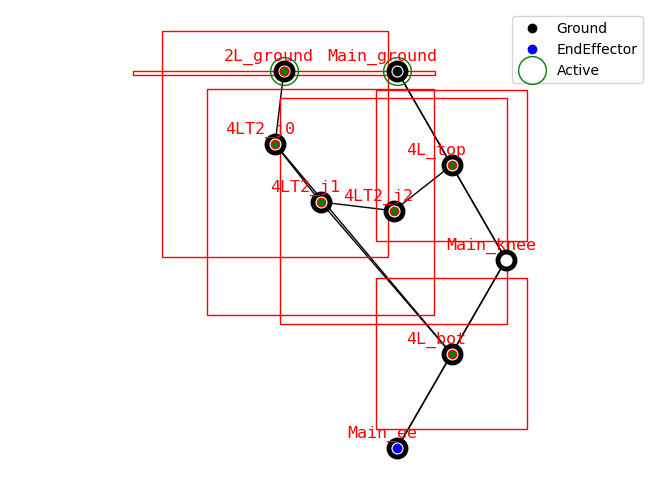

In [2]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[4]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

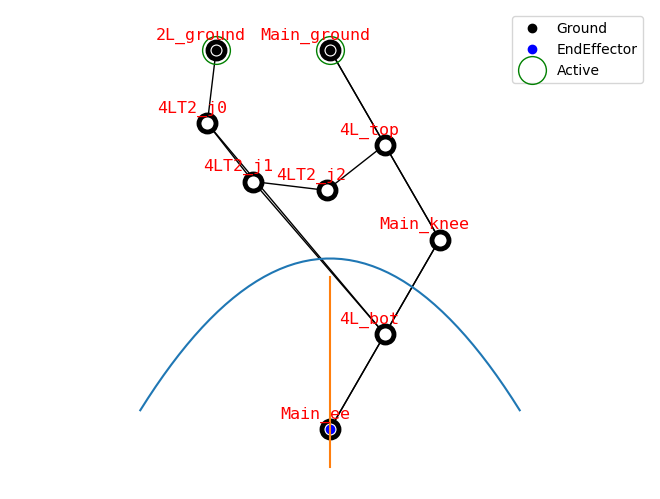

In [3]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -0.95], step_height= 0.4, step_width=1,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.65, -0.95], step_height= 0.4, step_width=1,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.35, -0.95], step_height= 0.4, step_width=1,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, -0.15,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.15,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (acceleration_capability, 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step]

heavy_lifting = HeavyLiftingReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")
rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (heavy_lifting, 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [4]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])


Best trajectory id: 0 partial rewards at best trajectory: [-0.236012568024113, 0]
Best trajectory id: 0 partial rewards at best trajectory: [-0.10783987503667834, 0]


In [5]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [6]:
population_size = 32
n_generations = 10

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -6.919057E-01 | -6.983534E+00
     2 |       64 |  0.22027 |       3 |  0.5417 |  2.00000 |  2.01680 | -1.560408E+00 | -7.642098E+00
     3 |       96 |  0.06668 |       3 |  0.4422 |  1.99181 |  2.03304 | -2.915440E+00 | -1.382824E+01
     4 |      128 |  0.00923 |       3 |  0.4058 |  1.97995 |  2.04825 | -6.419450E+00 | -1.382824E+01
     5 |      160 | -1.8E-02 |       3 |  0.3886 |  1.96673 |  2.05930 | -9.116912E+00 | -1.586810E+01
     6 |      192 | -2.1E-02 |       3 |  0.3870 |  1.95485 |  2.06998 | -1.137274E+01 | -1.708399E+01
     7 |      224 | -1.5E-02 |       3 |  0.3909 |  1.94354 |  2.07592 | -1.245223E+01 | -1.785508E+01
     8 |      256 | -1.2E-02 |       3 |  0.3927 |  1.93548 |  2.08992 | -1.396974E+01 | -1.867246E+01
     9 |      288 |  0.02222 |       3 |  0.4139 |  1.92509 |  2.10527 | 

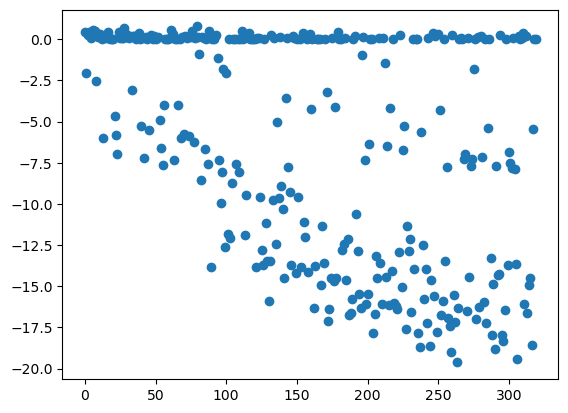

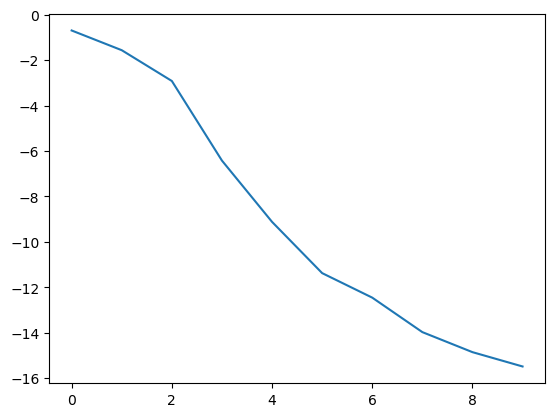

In [7]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [8]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.7716422546130262


The minimum result in optimization task: [-19.6279611]


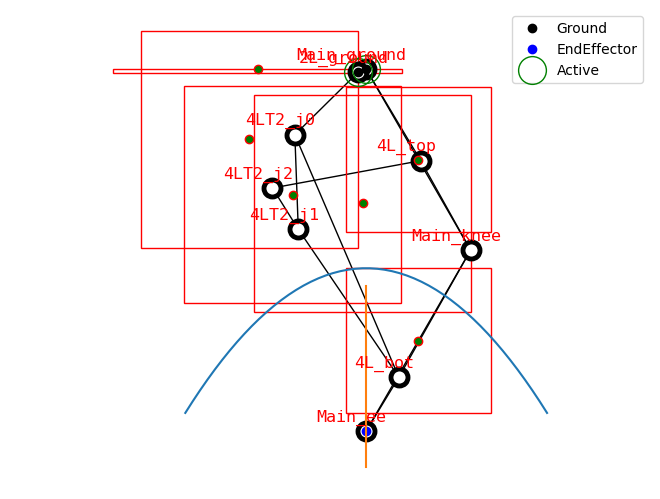

In [9]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [10]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.        ,  0.        , 12.74522084],
       [ 0.        ,  0.        ,  6.88274026]])

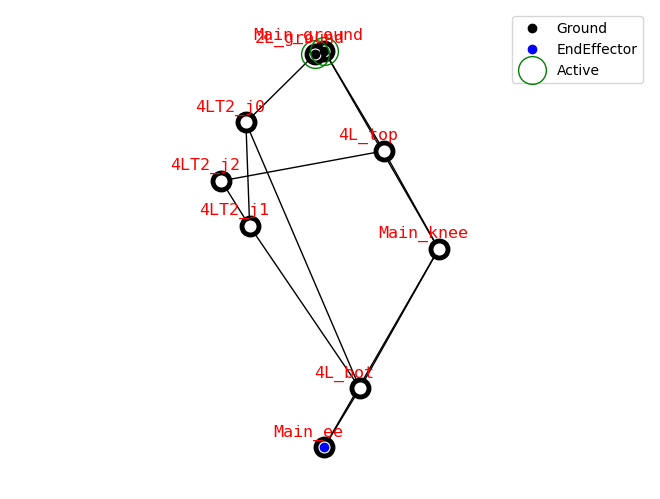

In [11]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

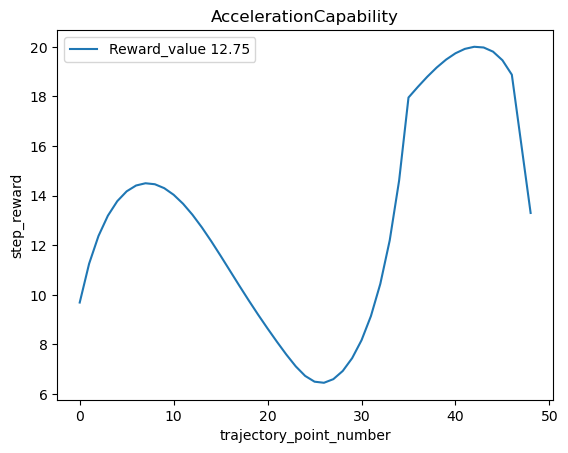

In [12]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

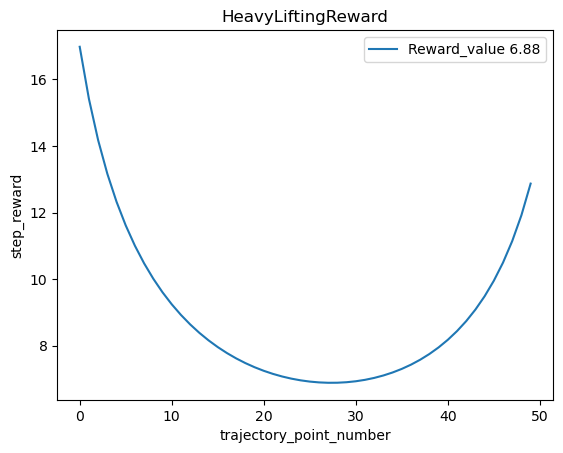

In [15]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[1]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[1][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLiftingReward')
plt.legend([f'Reward_value {round(reward,2)}'])

plt.show()


In [19]:
reward_vector

array([ 8.18672721,  9.09026793,  9.92452375, 10.70215129, 11.43259678,
       12.12325239, 12.78009865, 13.40810675, 14.01150225, 14.59394604,
       15.15866408, 15.70854498, 16.24622553, 16.77413475, 17.294558  ,
       17.80968027, 18.32160517, 18.83241921, 19.34419267, 19.85902734,
       20.37909191, 20.90664097, 21.44406486, 21.99392495, 22.55900056,
       23.14233091, 23.74731223, 24.37773956, 25.03792714, 25.7328144 ,
       26.42736742, 26.84999471, 27.27302826, 27.69626071, 28.11921251,
       28.54099259, 28.96024434, 29.37497154, 29.78235807, 30.1785353 ,
       30.55827996, 30.91457735, 31.23810426, 31.51650007, 31.73344955,
       31.86732282, 31.88943884, 31.76144905, 31.4316015 ])